# Analysis of DS9 Character Appearances and Episdoe Ratings

In [231]:
# import libaries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import requests
from config import apikey

plt.style.use('seaborn')

In [232]:
# api keys
# omdb (open movie database). get a free api key here: https://www.omdbapi.com/
apikey_omdb = apikey

## Read & Cleanup Star Trek Script JSON

In [233]:
# json file of all star trek scripts can be found here: https://www.kaggle.com/gjbroughton/start-trek-scripts 

# read in the json file
df = pd.read_json('all_series_lines.json')

In [234]:
# create list of episodes in ds9 series

ds9_episodes = df['DS9'].keys()

In [235]:
# count number of lines per character per episode and put in dataframe

episodes = []
characters = []
lines = []

for ep in np.arange(len(ds9_episodes)):

    if df['DS9'][ds9_episodes[ep]] is not np.NaN:
    
        for character in list(df['DS9'][ds9_episodes[ep]].keys()):
        
            line_count = len(df['DS9'][ds9_episodes[ep]][character])    
            
            episodes.append(ep)
            characters.append(character)
            lines.append(line_count)
            
df_ds9 = pd.DataFrame({'episode': episodes,
                       'character': characters,
                       'line_count': lines
                      })


In [236]:
# do a little cleanup

# clean up O'BRIEN names 
df_ds9['character'] = df_ds9['character'].replace(["youO'BRIEN", "wasO'BRIEN", "0'BRIEN"],"O'BRIEN")

# remove instances where line count equals zero
df_ds9 = df_ds9[df_ds9['line_count'] != 0]

# add 1 to episode to get real episode number
df_ds9['seriesEpisode'] = df_ds9['episode'] + 1

# delete original episode column
del df_ds9['episode']

df_ds9.head()

,character,line_count,seriesEpisode
0,JENNIFER,41,1
1,OPS,4,1
2,JASAD,13,1
3,PICARD,28,1
4,MAGGIE,1,1


In [237]:
# create a copy of the dataframe changing DAX to JADZIA
df_ds9_two_daxes = df_ds9.copy()
df_ds9_two_daxes['character'] = df_ds9['character'].replace(['DAX'],'JADZIA')

In [238]:
# replace EZRI character name with DAX
df_ds9['character'] = df_ds9['character'].replace(['EZRI'],'DAX')

In [239]:
# list 25 characters with most lines in entire series
top_characters = df_ds9.groupby('character')['line_count'].sum().sort_values(ascending=False).head(25)

In [240]:
# remove the computer as a character
top_characters_clean = top_characters[~top_characters.index.isin(['COMPUTER'])]

## Top 24 DS9 Characters with the Most Lines

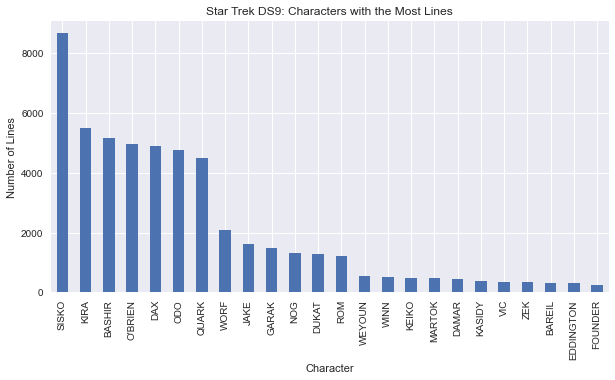

In [241]:
# plot the results
fig, ax = plt.subplots(figsize=(10,5))
top_characters_clean.plot.bar()
ax.set(title='Star Trek DS9: Characters with the Most Lines',
xlabel='Character',
ylabel='Number of Lines'
);

## Access OMDB API

In [242]:
# get omdb review data for all seasons and put in dataframe
url = 'http://www.omdbapi.com/'
title = 'deep+space+nine'

for season in np.arange(1,8):

    params = {'apikey': apikey_omdb,
              't': title,
              'season': season}

    response = requests.get(url, params)
    data = response.json()
    df_season = pd.DataFrame(data)
    
    if season == 1: 
        df_omdb = df_season
    
    else:   
        df_omdb = df_omdb.append(df_season)

df_omdb.reset_index(drop=True, inplace=True)

# split Episodes column in separate columns and put in dataframe
df_episodes = df_omdb['Episodes'].apply(pd.Series)

# rename show 'Title' as 'Series'
df_omdb = df_omdb.rename(columns={'Title': 'Series'})
df_omdb = df_omdb.join(df_episodes)
df_omdb["seriesEpisode"] = df_omdb.index + 1

## Read in Jammer Reviews

In [243]:
# put jammer reviews in dataframe
# reviews scraped from https://www.jammersreviews.com/

df_jammer = pd.read_csv('StarTrek_DS9_JammerReviews.csv')


## Merge Script Data and Ratings

In [244]:
# merge lines dataframe with jammer reviews datafraome
df_merge = df_ds9.merge(df_jammer, on='seriesEpisode', how='inner')

# sum total lines for each episode and merge
sum_lines_per_episode = df_merge.groupby('seriesEpisode')['line_count'].sum()
df_merge = df_merge.merge(sum_lines_per_episode, on='seriesEpisode', suffixes=('','_episode_total'))


## Plot of Character Lines in 4-Star Episodes (rating is out 4)

''

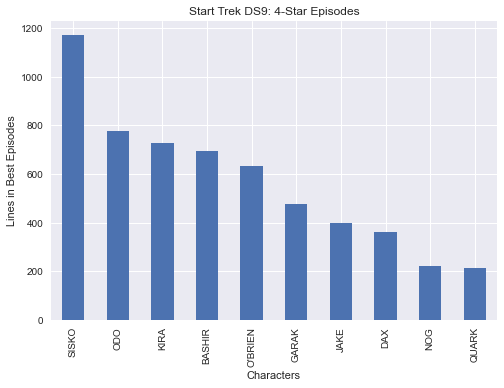

In [245]:
# find the four-star episodes
best_episodes = list(df_jammer[df_jammer['jammerStars'] == 4]['seriesEpisode'])
df_best_episodes = df_ds9[df_ds9['seriesEpisode'].isin(best_episodes)]

# sum lines for characters in worst episodes
top_best_characters = df_best_episodes.groupby('character')['line_count'].sum().sort_values(ascending=False).head(10)

# plot and annotate
fig, ax = plt.subplots()
top_best_characters.plot(kind='bar')
ax.set(title="Start Trek DS9: 4-Star Episodes",
        xlabel='Characters',
        ylabel='Lines in Best Episodes'
    )
;

## Plot of Character Lines in the Worst Episodes (sub 2-Star)
* Ferengi episodes are terrible
* Quark really deserved better

''

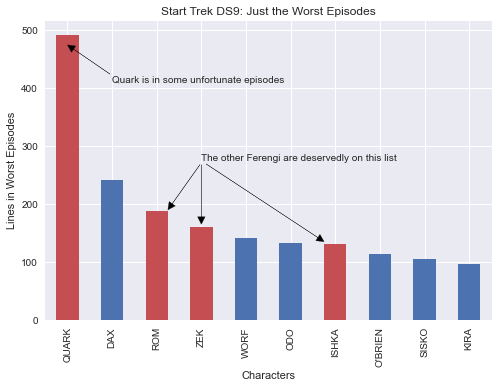

In [246]:
# find the worst episodes
worst_episodes = list(df_jammer[df_jammer['jammerStars'] < 2]['seriesEpisode'])
df_worst_episodes = df_ds9[df_ds9['seriesEpisode'].isin(worst_episodes)]

# sum lines for characters in worst episodes
top_worst_characters = df_worst_episodes.groupby('character')['line_count'].sum().sort_values(ascending=False).head(10)

# plot and annotate
fig, ax = plt.subplots()
top_worst_characters.plot(kind='bar', color=['C2', 'C0', 'C2', 'C2', 'C0', 'C0', 'C2', 'C0', 'C0', 'C0', ])
ax.set(title="Start Trek DS9: Just the Worst Episodes",
xlabel='Characters',
ylabel='Lines in Worst Episodes')
ax.annotate('Quark is in some unfortunate episodes', 
            xy=(0, 475),
            xytext=(1, 410),
            arrowprops=dict(facecolor='black', shrink=1, width=.01, headwidth=7.5, headlength=7.5)
            )
ax.annotate('The other Ferengi are deservedly on this list',
            xy=(2.25, 190),
            xytext=(3, 275),
            arrowprops=dict(facecolor='black', shrink=1, width=.01, headwidth=7.5, headlength=7.5)
            )
ax.annotate(' ',
            xy=(3, 165),
            xytext=(3, 275),
            arrowprops=dict(facecolor='black', shrink=1, width=.01, headwidth=7.5, headlength=7.5)
            )
ax.annotate(' ',
            xy=(5.75, 135),
            xytext=(3, 275),
            arrowprops=dict(facecolor='black', shrink=1, width=.01, headwidth=7.5, headlength=7.5)
            )
;

## Some Further Analysis...

### Determine each characters contribution to an episode (by share of lines)

In [247]:
# add in some addtional lines...

# calculate characters' lines as a portion of total episode lines
df_merge['episodeFraction'] = df_merge['line_count'] / df_merge['line_count_episode_total']

# set episode rating scale from -2 to 2
df_merge['episodeQuality'] = (df_merge['jammerStars'] - 2)

# attribute episode quality to characters based on number of lines
df_merge['ratingFraction'] = df_merge['episodeFraction'] * df_merge['episodeQuality']


### Attribute episode rating to characters based on contribution (i.e., share of lines in episdoe)

In [248]:
# determine characters' contribution to ratings for entire series 
ratingPoints = df_merge.groupby('character')['ratingFraction'].sum()
ratingPoints = ratingPoints.rename('ratingPoints')  
ratingPoints.sort_values(ascending=False).head()

character
SISKO      24.379196
KIRA       14.839808
BASHIR     12.965642
O'BRIEN    12.332863
ODO        12.150582
Name: ratingPoints, dtype: float64

### Determine characters' contribution to rating per episode appearance

In [249]:
# count number of episodes each character appears in
episodes_count = df_merge.groupby('character')['seriesEpisode'].count()
episodes_count = episodes_count.rename('episodes_count')
episodes_count.sort_values(ascending=False).head()

character
SISKO     173
KIRA      171
DAX       171
BASHIR    169
ODO       167
Name: episodes_count, dtype: int64

In [250]:
# create new dataframe including character, total rating points, and total episode appearances
df_final = pd.concat([ratingPoints, episodes_count], axis=1)

df_final['points_per_episode'] = df_final['ratingPoints'] / df_final['episodes_count']
df_final = df_final.sort_values(by='points_per_episode', ascending=False)

In [251]:
# select only characters with the most lines

df_final_top_24 = df_final[df_final.index.isin(top_characters_clean.index)]


## Plot of Characters' per Episode Contribution to Rating (limited to top 24 characters)

* Sisko and Garak are top
* Zek is really the worst (no surprises)

''

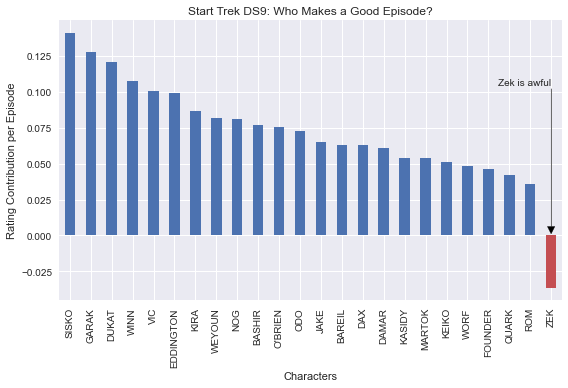

In [252]:
# plots results

# make characters with negative ratings red
color_list = []
for rating in df_final_top_24['points_per_episode']:
    if rating >= 0:
        color_list.append("C0")
    else:
        color_list.append("C2")

fig, ax = plt.subplots()
df_final_top_24['points_per_episode'].plot.bar(color=color_list)
ax.set(title="Start Trek DS9: Who Makes a Good Episode?",
xlabel='Characters',
ylabel='Rating Contribution per Episode')
ax.annotate('Zek is awful', 
            xy=(23, 0.001),
            xytext=(23, .105),
            arrowprops=dict(facecolor='black', shrink=1, width=.01, headwidth=7.5, headlength=7.5),
            horizontalalignment='right'
           )
fig.tight_layout()
;

## What about characters that don't appear often?
* I'll need to look a lot of theses characters up

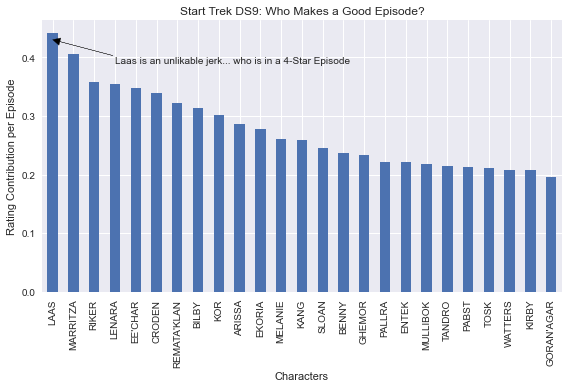

In [253]:
# select only characters outside the top characters

df_final_not_top_24 = df_final[~df_final.index.isin(top_characters_clean.index)].head(25)

# plots results
fig, ax = plt.subplots()
df_final_not_top_24['points_per_episode'].plot.bar()
ax.set(title="Start Trek DS9: Who Makes a Good Episode?",
xlabel='Characters',
ylabel='Rating Contribution per Episode')
ax.annotate('Laas is an unlikable jerk... who is in a 4-Star Episode', 
            xy=(0, 0.43),
            xytext=(3, .39),
            arrowprops=dict(facecolor='black', shrink=1, width=.01, headwidth=7.5, headlength=7.5),
            horizontalalignment='left'
            )
fig.tight_layout()

## Does removing the Absolute Worst Episides (0-Star) Make a Difference?
* I was hoping Quark would move up more!

''

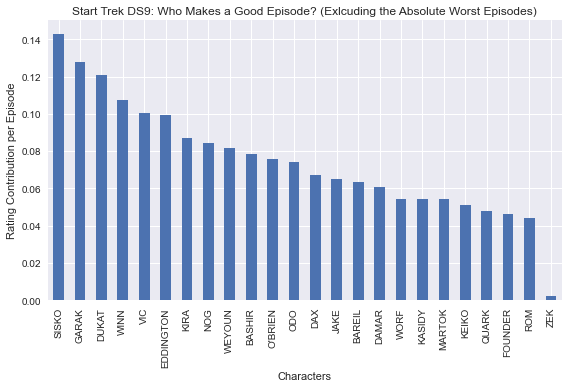

In [254]:
# merge lines dataframe with jammer reviews datafraome
df_merge = df_ds9.merge(df_jammer, on='seriesEpisode', how='inner')

# exclude the absoute worst 0-star episodes
df_no_bad_eps = df_merge[df_merge['jammerStars'] > 0]

# sum total lines for each episode and merge
sum_lines_per_episode = df_no_bad_eps.groupby('seriesEpisode')['line_count'].sum()
df_no_bad_eps = df_no_bad_eps.merge(sum_lines_per_episode, on='seriesEpisode', suffixes=('','_episode_total'))

# add in some addtional lines...

# calculate characters' lines as a portion of total episode lines
df_no_bad_eps['episodeFraction'] = df_no_bad_eps['line_count'] / df_no_bad_eps['line_count_episode_total']

# set episode rating scale from -2 to 2
df_no_bad_eps['episodeQuality'] = (df_no_bad_eps['jammerStars'] - 2)

# attribute episode quality to characters based on number of lines
df_no_bad_eps['ratingFraction'] = df_no_bad_eps['episodeFraction'] * df_no_bad_eps['episodeQuality']

# determine characters' contribution to ratings for entire series 
ratingPoints = df_no_bad_eps.groupby('character')['ratingFraction'].sum()
ratingPoints = ratingPoints.rename('ratingPoints')

# count number of episodes each character appears in
episodes_count = df_no_bad_eps.groupby('character')['seriesEpisode'].count()
episodes_count = episodes_count.rename('episodes_count')

# create new dataframe including character, total rating points, and total episoded appearances
df_final = pd.concat([ratingPoints, episodes_count], axis=1)

df_final['points_per_episode'] = df_final['ratingPoints'] / df_final['episodes_count']
df_final = df_final.sort_values(by='points_per_episode', ascending=False)
df_final = df_final[df_final.index.isin(top_characters_clean.index)]

# plots results
fig, ax = plt.subplots()
df_final['points_per_episode'].plot.bar()
ax.set(title="Start Trek DS9: Who Makes a Good Episode? (Exlcuding the Absolute Worst Episodes)",
xlabel='Characters',
ylabel='Rating Contribution per Episode')
fig.tight_layout()
;

## And as a bonus, which Dax is better? Jadzia or Ezri

''

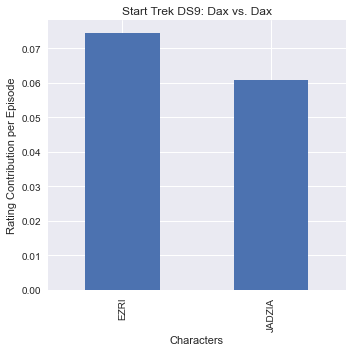

In [255]:
# merge lines dataframe with jammer reviews datafraome
df_merge = df_ds9_two_daxes.merge(df_jammer, on='seriesEpisode', how='inner')

# sum total lines for each episode and merge
sum_lines_per_episode = df_merge.groupby('seriesEpisode')['line_count'].sum()
df_merge = df_merge.merge(sum_lines_per_episode, on='seriesEpisode', suffixes=('','_episode_total'))

# add in some addtional lines...

# calculate characters' lines as a portion of total episode lines
df_merge['episodeFraction'] = df_merge['line_count'] / df_merge['line_count_episode_total']

# set episode rating scale from -2 to 2
df_merge['episodeQuality'] = (df_merge['jammerStars'] - 2)

# attribute episode quality to characters based on number of lines
df_merge['ratingFraction'] = df_merge['episodeFraction'] * df_merge['episodeQuality']

# determine characters' contribution to ratings for entire series 
ratingPoints = df_merge.groupby('character')['ratingFraction'].sum()
ratingPoints = ratingPoints.rename('ratingPoints')

# count number of episodes each character appears in
episodes_count = df_merge.groupby('character')['seriesEpisode'].count()
episodes_count = episodes_count.rename('episodes_count')

# create new dataframe including character, total rating points, and total episoded appearances
df_final = pd.concat([ratingPoints, episodes_count], axis=1)

df_final['points_per_episode'] = df_final['ratingPoints'] / df_final['episodes_count']
df_final = df_final.sort_values(by='points_per_episode', ascending=False)

# select only JADZIA and EZRI
df_final = df_final[df_final.index.isin(['JADZIA', 'EZRI'])]

# plots results
fig, ax = plt.subplots(figsize=(5,5))
df_final['points_per_episode'].plot.bar(color=color_list)
ax.set(title="Start Trek DS9: Dax vs. Dax",
xlabel='Characters',
ylabel='Rating Contribution per Episode')
fig.tight_layout()
;

In [256]:
#best couples, thruples, and quadruples?

# sisko & dukat
# sisko & winn
# jake & nog
# garak & bashir
# obrien & bashir
# kira & dukat
# kira & odo
# dukat & winn
# quark, rom, and nog
# quark & odo
# worf & dax
# worf & martok
# weyoun & damar

# ratings for O'Brien imprisoned episodes?
# quark in non-ferengi episodes